# EE610 Assignment 4

Reference: https://www.youtube.com/watch?v=M3EZS__Z_XE&t=845s

Github: https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb

In [698]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [699]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
import keras.backend as K

import os
import sys

# Data generation

In [700]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=10, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name)
        mask_path = os.path.join(self.path, "masks",id_name)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        
        ## Reading Masks
        mask = cv2.imread(mask_path, -1)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(mask, axis=-1)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask


    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [701]:
epochs = 8
batch_size = 2
image_size = 128

In [702]:
train_path = "/content/drive/MyDrive/IP/images/"

## Training Ids
train_ids = next(os.walk(train_path))[2]

## Validation Data Size
val_data_size = 1

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]
train_ids

['TCGA-49-4488-01Z-00-DX1.png',
 'TCGA-50-5931-01Z-00-DX1.png',
 'TCGA-21-5784-01Z-00-DX1.png',
 'TCGA-38-6178-01Z-00-DX1.png',
 'TCGA-A7-A13E-01Z-00-DX1.png',
 'TCGA-21-5786-01Z-00-DX1.png',
 'TCGA-AY-A8YK-01A-01-TS1.png',
 'TCGA-AR-A1AS-01Z-00-DX1.png',
 'TCGA-B0-5698-01Z-00-DX1.png',
 'TCGA-AR-A1AK-01Z-00-DX1.png',
 'TCGA-A7-A13F-01Z-00-DX1.png',
 'TCGA-B0-5710-01Z-00-DX1.png',
 'TCGA-CH-5767-01Z-00-DX1.png',
 'TCGA-E2-A1B5-01Z-00-DX1.png',
 'TCGA-DK-A2I6-01A-01-TS1.png',
 'TCGA-B0-5711-01Z-00-DX1.png',
 'TCGA-E2-A14V-01Z-00-DX1.png',
 'TCGA-G9-6348-01Z-00-DX1.png',
 'TCGA-G2-A2EK-01A-02-TSB.png',
 'TCGA-G9-6336-01Z-00-DX1.png',
 'TCGA-HE-7130-01Z-00-DX1.png',
 'TCGA-G9-6362-01Z-00-DX1.png',
 'TCGA-HE-7128-01Z-00-DX1.png',
 'TCGA-G9-6363-01Z-00-DX1.png',
 'TCGA-G9-6356-01Z-00-DX1.png',
 'TCGA-HE-7129-01Z-00-DX1.png',
 'TCGA-KB-A93J-01A-01-TS1.png',
 'TCGA-NH-A8F7-01A-01-TS1.png',
 'TCGA-RD-A8N9-01A-01-TS1.png']

In [703]:
test_path = "/content/drive/MyDrive/IP/test_images/"
## Test Ids
test_ids = next(os.walk(test_path))[2]
test_ids

['TCGA-A6-6782-01A-01-BS1.png',
 'TCGA-69-7764-01A-01-TS1.png',
 'TCGA-44-2665-01B-06-BS6.png',
 'TCGA-2Z-A9J9-01A-01-TS1.png',
 'TCGA-GL-6846-01A-01-BS1.png',
 'TCGA-FG-A4MU-01B-01-TS1.png',
 'TCGA-EJ-A46H-01A-03-TSC.png',
 'TCGA-CU-A0YN-01A-02-BSB.png',
 'TCGA-AO-A0J2-01A-01-BSA.png',
 'TCGA-AC-A2FO-01A-01-TS1.png',
 'TCGA-ZF-A9R5-01A-01-TS1.png',
 'TCGA-IZ-8196-01A-01-BS1.png',
 'TCGA-HT-8564-01Z-00-DX1.png',
 'TCGA-HC-7209-01A-01-TS1.png']

In [704]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(2, 128, 128, 3) (2, 128, 128, 1)


In [705]:
gen = DataGen(test_ids, test_path, batch_size=14, image_size=image_size)
xtest, ytest = gen.__getitem__(0)
print(xtest.shape, ytest.shape)

(14, 128, 128, 3) (14, 128, 128, 1)


# Train examples

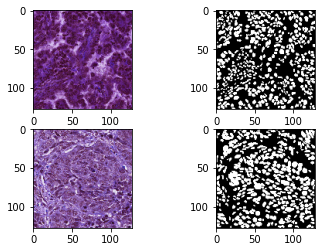

In [706]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x[0])
ax = fig.add_subplot(2, 2, 2)
ax.imshow(np.reshape(y[0], (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(2, 2, 3)
ax.imshow(x[1])
ax = fig.add_subplot(2, 2, 4)
ax.imshow(np.reshape(y[1], (image_size, image_size)), cmap="gray")

# Testing example

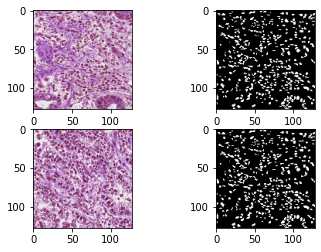

In [707]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(2, 2, 1)
ax.imshow(xtest[0])
ax = fig.add_subplot(2, 2, 2)
ax.imshow(np.reshape(ytest[0], (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(2, 2, 3)
ax.imshow(xtest[1])
ax = fig.add_subplot(2, 2, 4)
ax.imshow(np.reshape(ytest[0], (image_size, image_size)), cmap="gray")

# Layers of UNet

In [708]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

# Unet

In [709]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

# Dice Loss function

Reference: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

In [715]:
def DiceLoss(targets, inputs, smooth=1e-5):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets*inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

# Setting model metrics

In [711]:
model = UNet()
model.compile(optimizer="SGD", loss=DiceLoss, metrics=["acc"])
model.summary()

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_779 (Conv2D)            (None, 128, 128, 16  448         ['input_42[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_780 (Conv2D)            (None, 128, 128, 16  2320        ['conv2d_779[0][0]']             
                                )                                                          

# Training

In [712]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = 1

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, 
                    validation_steps=valid_steps, epochs=epochs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/8
14/14 [==============================] - 8s 401ms/step - loss: 0.6376 - acc: 0.6489 - val_loss: 0.5592 - val_acc: 0.5612
Epoch 2/8
14/14 [==============================] - 5s 336ms/step - loss: 0.6592 - acc: 0.5643 - val_loss: 0.5533 - val_acc: 0.4221
Epoch 3/8
14/14 [==============================] - 5s 336ms/step - loss: 0.6523 - acc: 0.3300 - val_loss: 0.5485 - val_acc: 0.3698
Epoch 4/8
14/14 [==============================] - 6s 445ms/step - loss: 0.6836 - acc: 0.2105 - val_loss: 0.5450 - val_acc: 0.3694
Epoch 5/8
14/14 [==============================] - 5s 328ms/step - loss: 0.6495 - acc: 0.2380 - val_loss: 0.5414 - val_acc: 0.3694
Epoch 6/8
14/14 [==============================] - 5s 333ms/step - loss: 0.6696 - acc: 0.2180 - val_loss: 0.5383 - val_acc: 0.3694
Epoch 7/8
14/14 [==============================] - 5s 324ms/step - loss: 0.6312 - acc: 0.2568 - val_loss: 0.5350 - val_acc: 0.3694
Epoch 8/8
14/14 [==============================] - 5s 335ms/step - loss: 0.6628 - a

# Saving weights

In [713]:
model.save_weights("UNetWeights.h5")
result = model.predict(xtest)

result = result > 0.5

1/1 [==============================] - 1s 846ms/step


# Testing

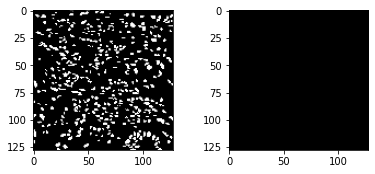

In [714]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(ytest[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")